In [1]:
!python --version
!pip show torch random numpy seaborn matplotlib scikit-learn | findstr "Name Version"

Python 3.10.10
Name: torch
Version: 2.6.0
Name: numpy
Version: 2.0.2
        Name: lapack-lite
        Name: dragon4
        Name: libdivide
        Name: Meson
        Name: spin
        Name: OpenBLAS
        Name: LAPACK
        Name: GCC runtime library
        Version 3.1, 31 March 2009
                               Version 3, 29 June 2007
          5. Conveying Modified Source Versions.
          14. Revised Versions of this License.
Name: seaborn
Version: 0.13.2
Name: matplotlib
Version: 3.10.1
Name: scikit-learn
Version: 1.6.1
         Name: Microsoft Visual C++ Runtime Files


### 提示

若只想测试已有模型分类准确率，请自上而下依次运行单元格（或禁用最后一个单元格（训练）后点击全部运行）

### 加载数据集


In [2]:
import torch
import random
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# 数据增强
class DataSetOpt:
    def __init__(self, add_gaussian_noise=True, mean=0.0, std=0.03, use_cutout=True, num_holes=1, size=4):
        # 高斯噪声
        self.add_gaussian_noise = add_gaussian_noise
        self.mean = mean
        self.std = std
        # Cutout
        self.use_cutout = use_cutout
        self.num_holes = num_holes
        self.size = size

    def __call__(self, img):
        if self.add_gaussian_noise:
            img = img + torch.randn(img.size()) * self.std + self.mean
        if self.use_cutout:
            h, w = img.size(1), img.size(2)
            for _ in range(self.num_holes):
                y = random.randint(0, h)
                x = random.randint(0, w)
                img[
                    :,
                    max(0, y - self.size // 2) : min(h, y + self.size // 2),
                    max(0, x - self.size // 2) : min(w, x + self.size // 2),
                ] = 0

        return img

In [9]:
torch.manual_seed(42)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)
# 先几何变换再裁剪比较适合分类任务，不然容易丢失全局特征
# 强数据增强（前期）
# 数据增强还是不太适合乱搞，之前本来都练出82%的准确率了，乱搞一通掉到70%
strong_transforms = transforms.Compose(
    [
        AutoAugment(policy=AutoAugmentPolicy.CIFAR10),  # 包含注释掉的那些了
        transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
        # transforms.RandomAffine(
        #    degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)
        # ),  # 平移和缩放
        # transforms.RandomCrop(24),  # 随机裁剪为 24x24
        # transforms.Resize(32),  # 恢复到 32x32，确保后面输入正常
        # transforms.ColorJitter(
        #    brightness=0.2, contrast=0.2, saturation=0.2
        # ),  # 颜色扰动
        transforms.ToTensor(),
        DataSetOpt(std=0.03, use_cutout=True),  # 高斯噪声和 Cutout
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)
# 弱数据增强（后期）
weak_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
        transforms.RandomCrop(32, padding=4),  # 随机裁剪
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)

# 加载完整数据集
train_dataset = datasets.CIFAR100(
    root="./data", train=True, download=True, transform=strong_transforms
)
test_dataset = datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)


# 随机抽取数据
def get_subset(dataset, ratio=1):
    indices = np.random.choice(
        len(dataset), size=int(len(dataset) * ratio), replace=False
    )
    return Subset(dataset, indices)

print("原始训练集大小：", len(train_dataset))
print("原始测试集大小：", len(test_dataset))
train_subset = get_subset(train_dataset)
test_subset = get_subset(test_dataset)
imgSize = train_subset[0][0].shape[1]
print("图像尺寸" + str(imgSize) + "x" + str(imgSize))

100%|██████████| 169M/169M [00:35<00:00, 4.79MB/s] 


原始训练集大小： 50000
原始测试集大小： 10000
图像尺寸32x32


### 数据集二次划分

In [10]:
# 划分验证集
validation_size = int(0.2 * len(train_subset))
train_size = len(train_subset) - validation_size
train_subset, validation_subset = torch.utils.data.random_split(
    train_subset, [train_size, validation_size]
)

DL_batch_size = 1024
train_loader = DataLoader(train_subset, batch_size=DL_batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_subset, batch_size=DL_batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=DL_batch_size, num_workers=2, pin_memory=True)

print(
    f"训练样本数: {len(train_subset)}, 验证样本数: {len(validation_subset)}, 测试样本数: {len(test_subset)}"
)

训练样本数: 40000, 验证样本数: 10000, 测试样本数: 10000


### 随机展示

五张图及其经过数据增强后的样子，方便调整数据增强措施

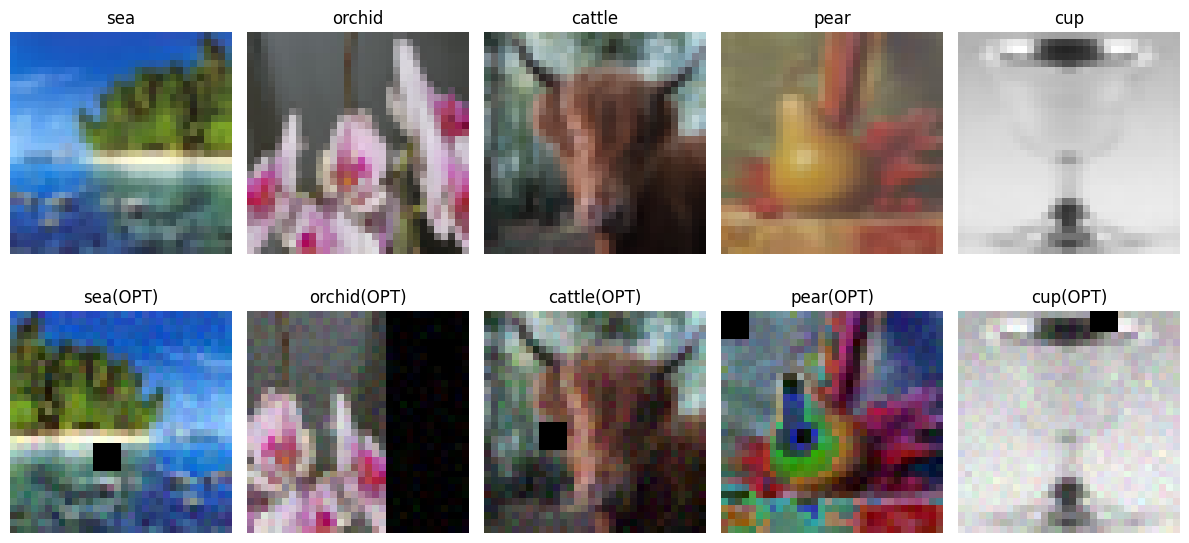

训练集统计信息:
数据集大小: 50000
通道数: 3，图像尺寸: 32x32
类别分布:
    apple: 500 张
    aquarium_fish: 500 张
    baby: 500 张
    bear: 500 张
    beaver: 500 张
    bed: 500 张
    bee: 500 张
    beetle: 500 张
    bicycle: 500 张
    bottle: 500 张
    bowl: 500 张
    boy: 500 张
    bridge: 500 张
    bus: 500 张
    butterfly: 500 张
    camel: 500 张
    can: 500 张
    castle: 500 张
    caterpillar: 500 张
    cattle: 500 张
    chair: 500 张
    chimpanzee: 500 张
    clock: 500 张
    cloud: 500 张
    cockroach: 500 张
    couch: 500 张
    crab: 500 张
    crocodile: 500 张
    cup: 500 张
    dinosaur: 500 张
    dolphin: 500 张
    elephant: 500 张
    flatfish: 500 张
    forest: 500 张
    fox: 500 张
    girl: 500 张
    hamster: 500 张
    house: 500 张
    kangaroo: 500 张
    keyboard: 500 张
    lamp: 500 张
    lawn_mower: 500 张
    leopard: 500 张
    lion: 500 张
    lizard: 500 张
    lobster: 500 张
    man: 500 张
    maple_tree: 500 张
    motorcycle: 500 张
    mountain: 500 张
    mouse: 500 张
    mushroom: 500 张
    oak

In [12]:
cifar10_classes = [
    "apple", "aquarium_fish", "baby", "bear", "beaver",
    "bed", "bee", "beetle", "bicycle", "bottle",
    "bowl", "boy", "bridge", "bus", "butterfly",
    "camel", "can", "castle", "caterpillar", "cattle",
    "chair", "chimpanzee", "clock", "cloud", "cockroach",
    "couch", "crab", "crocodile", "cup", "dinosaur",
    "dolphin", "elephant", "flatfish", "forest", "fox",
    "girl", "hamster", "house", "kangaroo", "keyboard",
    "lamp", "lawn_mower", "leopard", "lion", "lizard",
    "lobster", "man", "maple_tree", "motorcycle", "mountain",
    "mouse", "mushroom", "oak_tree", "orange", "orchid",
    "otter", "palm_tree", "pear", "pickup_truck", "pine_tree",
    "plain", "plate", "poppy", "porcupine", "possum",
    "rabbit", "raccoon", "ray", "road", "rocket",
    "rose", "sea", "seal", "shark", "shrew",
    "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table",
    "tank", "telephone", "television", "tiger", "tractor",
    "train", "trout", "tulip", "turtle", "wardrobe",
    "whale", "willow_tree", "wolf", "woman", "worm",
]

# 随机选择 5 张图像
show_size = 5
show_imgs = random.sample(range(len(train_dataset)), show_size)

_, axes = plt.subplots(2, show_size, figsize=(12, 6))

for i, idx in enumerate(show_imgs):
    # 数据增强后的图需要变换回来才能正常显示
    opt_img, _ = train_dataset[idx]
    opt_img = opt_img.numpy().transpose((1, 2, 0))

    # 反归一化（不然颜色会变得非常奇怪非常深，第一次跑的时候还以为我的数据增强出了什么问题）
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    opt_img = std * opt_img + mean
    opt_img = np.clip(opt_img, 0, 1)

    axes[0, i].imshow(train_dataset.data[idx])
    axes[0, i].set_title(f"{cifar10_classes[train_dataset.targets[idx]]}")
    axes[0, i].axis("off")

    axes[1, i].imshow(opt_img)
    axes[1, i].set_title(f"{cifar10_classes[train_dataset.targets[idx]]}(OPT)")
    axes[1, i].axis("off")


def dataset_info(dataset):
    print(f"数据集大小: {len(dataset)}")

    # 获取图像形状
    img_shape = dataset[0][0].shape
    print(f"通道数: {img_shape[0]}，图像尺寸: {img_shape[1]}x{img_shape[2]}")

    # 提取所有标签
    labels = [dataset[i][1] for i in range(len(dataset))]
    labels, counts = np.unique(labels, return_counts=True)  # 统计每个类别的数量

    print("类别分布:")
    for label, cnt in zip(labels, counts):
        print(f"    {cifar10_classes[label]}: {cnt} 张")

    # 计算每通道均值和标准差
    forAll = torch.stack([dataset[i][0] for i in range(len(dataset))])  # 将所有图像堆叠为一个张量
    forAll = forAll.view(-1, img_shape[0], img_shape[1] * img_shape[2])  # 展平

    print(f"每通道均值: {forAll.mean(dim=(0, 2)).numpy()}")
    print(f"每通道标准差: {forAll.std(dim=(0, 2)).numpy()}")
    print(f"像素值范围: {forAll.min().item()} ~ {forAll.max().item()}")


plt.tight_layout()
plt.show()

print("训练集统计信息:")
dataset_info(train_dataset)

print("\n测试集统计信息:")
dataset_info(test_dataset)

### 模型搭建

最大池化适合提取显著特征，平均池化适合分割图像，所以这里选最大池化`Maxpool2d`


- 卷积部分：
  - 保留原先的三组结构，每组内使用两组卷积层（包含各自的`BatchNorm`和`ReLU`），最后的输出依然经过最大池化
  - 各组内的第二个卷积层保持输入维度与输出维度等同（即继续提取更多内容，同时保持计算效率和稳定性）
  - 第一组的输出维度扩大到`128`，后续各组的输入与输出依然保持一倍的增幅
  - 其余参数不变
    - 对`CIFAR-10`任务，似乎设置`kernel_size`为`3x3`比较好
- 全连接部分：
  - 新增一个全连接层，每个全连接层之间新增一个`BatchNorm`，不过`Dropout`只需要一层就够了（不然丢得太多影响会很大）

In [59]:
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32/2 , 32/2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16/2 , 16/2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8/2 , 8/2   -> 4x4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # 第一组卷积层
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 池化    16x16

            # 第二组卷积层
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 池化    8x8

            # 第三组卷积层
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 池化    4x4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 100),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### 训练、验证

sgd比较适合小数据和简单模型，adam更适合分类问题

In [14]:
class ModelTrainer:
    def __init__(self, model, train_loader, validation_loader, epochs=200, lr=0.01):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.epochs = epochs
        self.lr = lr

        self.loss_func = nn.CrossEntropyLoss()  # 交叉熵损失函数适合分类  标签平滑的效果好像不是那么好
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)  # 加上正则化前期震荡有点大，需要微调，但是现在效果已经很好了就不加了
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optim, "min", patience=5
        )
        self.max_acc = 0.0

        # 拿来画图的
        self.train_losses, self.validation_losses = [], []
        self.train_accs, self.validation_accs = [], []

    def train(self):
        for epoch in range(self.epochs):
            # 动态切换数据增强策略
            if epoch == 55:  # 换到弱增强，这时候泛化能力已经不错了，希望能多学一点
                train_dataset.transform = weak_transforms
            elif epoch == 70:   # 关闭增强
                train_dataset.transform = transform

            # 训练
            train_loss, train_acc = self.train_part()

            # 验证
            validation_loss, validation_acc = self.validation_part()

            # 调整学习率
            self.scheduler.step(validation_loss)

            # 保存最佳模型
            if validation_acc > self.max_acc:
                self.max_acc = validation_acc
                torch.save(self.model.state_dict(), "CIFAR100_CNN.pth")

            print(f"Epoch {epoch+1}/{self.epochs}")
            print(
                f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | validation Loss: {validation_loss:.4f}, Acc: {validation_acc:.4f}"
            )

        return self.train_losses, self.validation_losses, self.train_accs, self.validation_accs

    def train_part(self):
        self.model.train()
        loss_sum = 0.0
        correct_cnt = 0
        total = 0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optim.zero_grad()                  # 梯度清零
            outputs = self.model(inputs)            # 调用上面搭建的前向传播
            loss = self.loss_func(outputs, labels)  # 计算损失
            loss.backward()                         # 反向传播，计算梯度
            self.optim.step()                       # 更新参数

            loss_sum += loss.item()
            total += labels.size(0)     # 加载多少算多少
            _, predicted = torch.max(outputs, 1)    # 新版torch可以直接传，不需要带.data
            correct_cnt += (predicted == labels).sum().item()

        train_loss = loss_sum / total
        train_acc = correct_cnt / total
        self.train_losses.append(train_loss)
        self.train_accs.append(train_acc)
        return train_loss, train_acc

    def validation_part(self):
        self.model.eval()
        validation_loss = 0.0
        correct_cnt = 0
        total = 0
        with torch.no_grad():  # 验证阶段不需要计算梯度
            for inputs, labels in self.validation_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                validation_loss += self.loss_func(outputs, labels).item()

                total += labels.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_cnt += (predicted == labels).sum().item()

        validation_loss = validation_loss / total
        validation_acc = correct_cnt / total
        self.validation_losses.append(validation_loss)
        self.validation_accs.append(validation_acc)
        return validation_loss, validation_acc

print("单元格加载成功")

单元格加载成功


### 测试


In [15]:
# 保存预测出错图片信息
error_images = {0: [], 1: [], 2: []}  # 0: {35,98}, 1: {98,46}, 2: {11,46}
error_labels = {0: [], 1: [], 2: []}  # 真实标签
error_preds = {0: [], 1: [], 2: []}  # 预测标签

# 错误率比较高的三组
label_sets = [{35, 98}, {98, 46}, {11, 46}]

def evaluate_model(model, test_loader, model_path="CIFAR100_CNN.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    test_labels = []
    test_preds = []
    confusion_matrix_approx = np.zeros((100, 100), dtype=int)  # 初始化 100x100 矩阵

    with torch.no_grad():
        correct_cnt = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.size(0)

            _, predicted = torch.max(model(inputs), 1)
            correct_cnt += (predicted == labels).sum().item()

            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())

            # 更新近似混淆矩阵
            for true_label, pred_label in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                confusion_matrix_approx[true_label, pred_label] += 1

            # 展示错误分类
            if (
                len(error_images[0]) == 3
                and len(error_images[1]) == 3
                and len(error_images[2]) == 3
            ):
                continue
            for i in range(len(labels)):
                true_label = labels[i].item()
                pred_label = predicted[i].item()
                if true_label != pred_label:
                    for idx, label_set in enumerate(label_sets):
                        if true_label in label_set and pred_label in label_set:
                            if len(error_images[idx]) < 3:  # 展示三张
                                error_images[idx].append(inputs[i].cpu())
                                error_labels[idx].append(true_label)
                                error_preds[idx].append(pred_label)
                            else:
                                break
                if (
                    len(error_images[0]) == 3
                    and len(error_images[1]) == 3
                    and len(error_images[2]) == 3
                ):
                    break
    print(f"Test Accuracy: {correct_cnt / total:.4f}")

    # 计算每个分类的准确率
    rp = classification_report(
        test_labels,
        test_preds,
        target_names=[str(i) for i in range(100)],
        output_dict=True,
    )
    accuracies = [(i, rp[str(i)]['precision']) for i in range(100)]
    accuracies.sort(key=lambda x: x[1])

    print("Class accuracies (sorted):")
    for class_id, accuracy in accuracies:
        print(f"Class {cifar10_classes[class_id]}: {accuracy:.4f}")

    # 输出混淆矩阵
    print("Confusion Matrix:")
    print(str(confusion_matrix_approx))

    # 展示错误分类的图片
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    _, axes = plt.subplots(3, 3, figsize=(12, 8))
    for i in range(3):  # 遍历每类
        for j in range(3):  # 每类展示3张
            img = error_images[i][j].permute(1, 2, 0).numpy()
            img = std * img + mean
            img = np.clip(img, 0, 1)

            axes[i, j].imshow(img)
            axes[i, j].set_title(
                f"True: {cifar10_classes[error_labels[i][j]]}, Pred: {cifar10_classes[error_preds[i][j]]}"
            )
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

### 快速评测

Test Accuracy: 0.6388
Class accuracies (sorted):
Class otter: 0.2650
Class lizard: 0.3143
Class girl: 0.3176
Class seal: 0.3600
Class mouse: 0.3964
Class woman: 0.3980
Class squirrel: 0.4158
Class bear: 0.4167
Class turtle: 0.4217
Class lobster: 0.4224
Class shark: 0.4250
Class rabbit: 0.4272
Class beaver: 0.4393
Class crocodile: 0.4444
Class man: 0.4444
Class shrew: 0.4486
Class possum: 0.4536
Class baby: 0.4667
Class boy: 0.4940
Class willow_tree: 0.5200
Class fox: 0.5333
Class tulip: 0.5393
Class snail: 0.5437
Class caterpillar: 0.5487
Class ray: 0.5488
Class snake: 0.5657
Class forest: 0.5684
Class couch: 0.5714
Class dolphin: 0.5727
Class kangaroo: 0.5825
Class lamp: 0.5895
Class whale: 0.5895
Class oak_tree: 0.5915
Class butterfly: 0.5918
Class leopard: 0.5926
Class mushroom: 0.5938
Class camel: 0.6061
Class bowl: 0.6145
Class bed: 0.6147
Class bee: 0.6161
Class tiger: 0.6170
Class streetcar: 0.6210
Class poppy: 0.6306
Class sweet_pepper: 0.6316
Class crab: 0.6344
Class beetle: 0

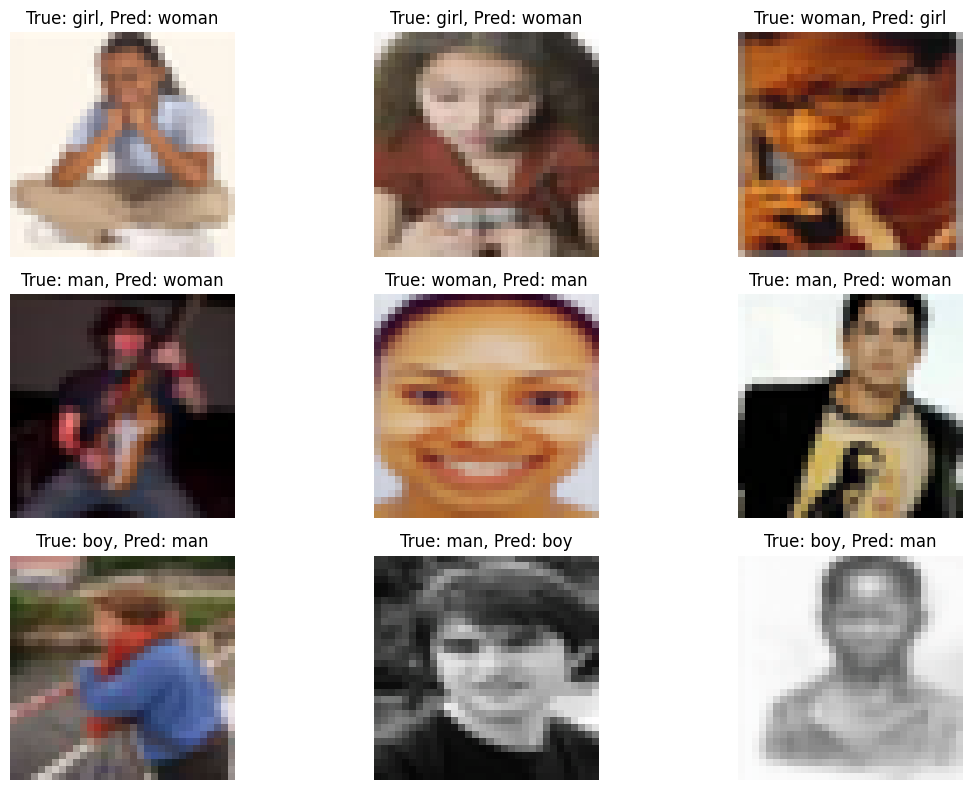

In [16]:
evaluate_model(SimpleCNN(), test_loader, "CIFAR100_CNN.pth")

### 训练&测试

Epoch 1/90
Train Loss: 0.0038, Acc: 0.1167 | validation Loss: 0.0032, Acc: 0.1933
Epoch 2/90
Train Loss: 0.0030, Acc: 0.2205 | validation Loss: 0.0029, Acc: 0.2582
Epoch 3/90
Train Loss: 0.0028, Acc: 0.2825 | validation Loss: 0.0026, Acc: 0.3113
Epoch 4/90
Train Loss: 0.0026, Acc: 0.3222 | validation Loss: 0.0025, Acc: 0.3324
Epoch 5/90
Train Loss: 0.0025, Acc: 0.3474 | validation Loss: 0.0024, Acc: 0.3523
Epoch 6/90
Train Loss: 0.0024, Acc: 0.3713 | validation Loss: 0.0023, Acc: 0.3803
Epoch 7/90
Train Loss: 0.0023, Acc: 0.3937 | validation Loss: 0.0023, Acc: 0.3841
Epoch 8/90
Train Loss: 0.0022, Acc: 0.4103 | validation Loss: 0.0022, Acc: 0.4091
Epoch 9/90
Train Loss: 0.0021, Acc: 0.4309 | validation Loss: 0.0022, Acc: 0.4220
Epoch 10/90
Train Loss: 0.0020, Acc: 0.4435 | validation Loss: 0.0022, Acc: 0.4288
Epoch 11/90
Train Loss: 0.0020, Acc: 0.4610 | validation Loss: 0.0022, Acc: 0.4265
Epoch 12/90
Train Loss: 0.0020, Acc: 0.4669 | validation Loss: 0.0021, Acc: 0.4428
Epoch 13/90
T

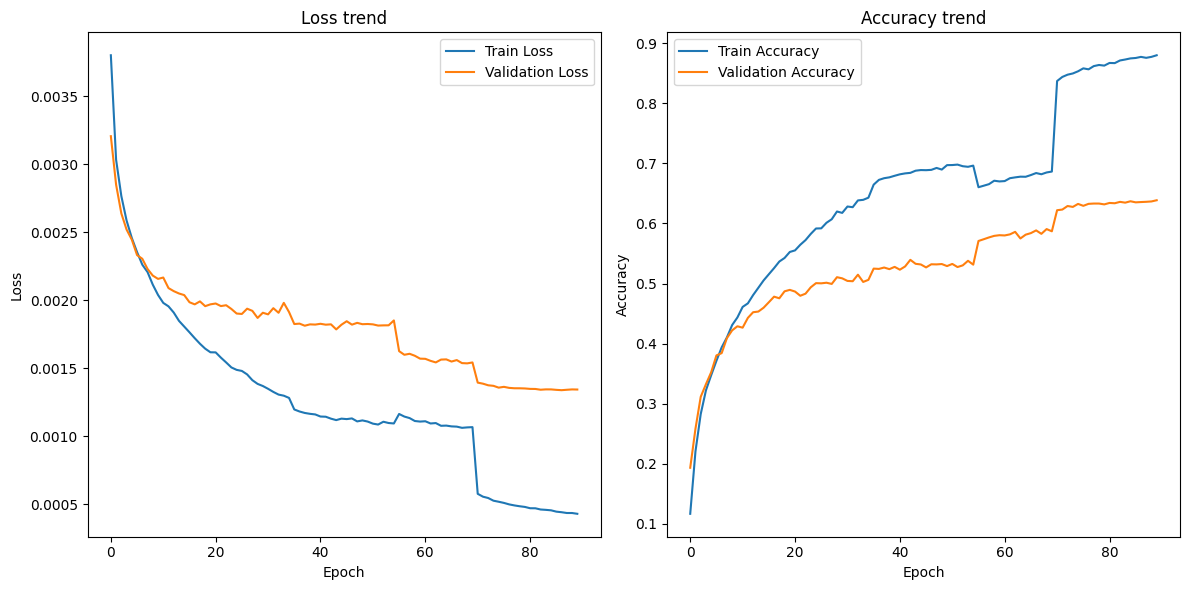

Test Accuracy: 0.6388
Class accuracies (sorted):
Class otter: 0.2650
Class lizard: 0.3143
Class girl: 0.3176
Class seal: 0.3600
Class mouse: 0.3964
Class woman: 0.3980
Class squirrel: 0.4158
Class bear: 0.4167
Class turtle: 0.4217
Class lobster: 0.4224
Class shark: 0.4250
Class rabbit: 0.4272
Class beaver: 0.4393
Class crocodile: 0.4444
Class man: 0.4444
Class shrew: 0.4486
Class possum: 0.4536
Class baby: 0.4667
Class boy: 0.4940
Class willow_tree: 0.5200
Class fox: 0.5333
Class tulip: 0.5393
Class snail: 0.5437
Class caterpillar: 0.5487
Class ray: 0.5488
Class snake: 0.5657
Class forest: 0.5684
Class couch: 0.5714
Class dolphin: 0.5727
Class kangaroo: 0.5825
Class lamp: 0.5895
Class whale: 0.5895
Class oak_tree: 0.5915
Class butterfly: 0.5918
Class leopard: 0.5926
Class mushroom: 0.5938
Class camel: 0.6061
Class bowl: 0.6145
Class bed: 0.6147
Class bee: 0.6161
Class tiger: 0.6170
Class streetcar: 0.6210
Class poppy: 0.6306
Class sweet_pepper: 0.6316
Class crab: 0.6344
Class beetle: 0

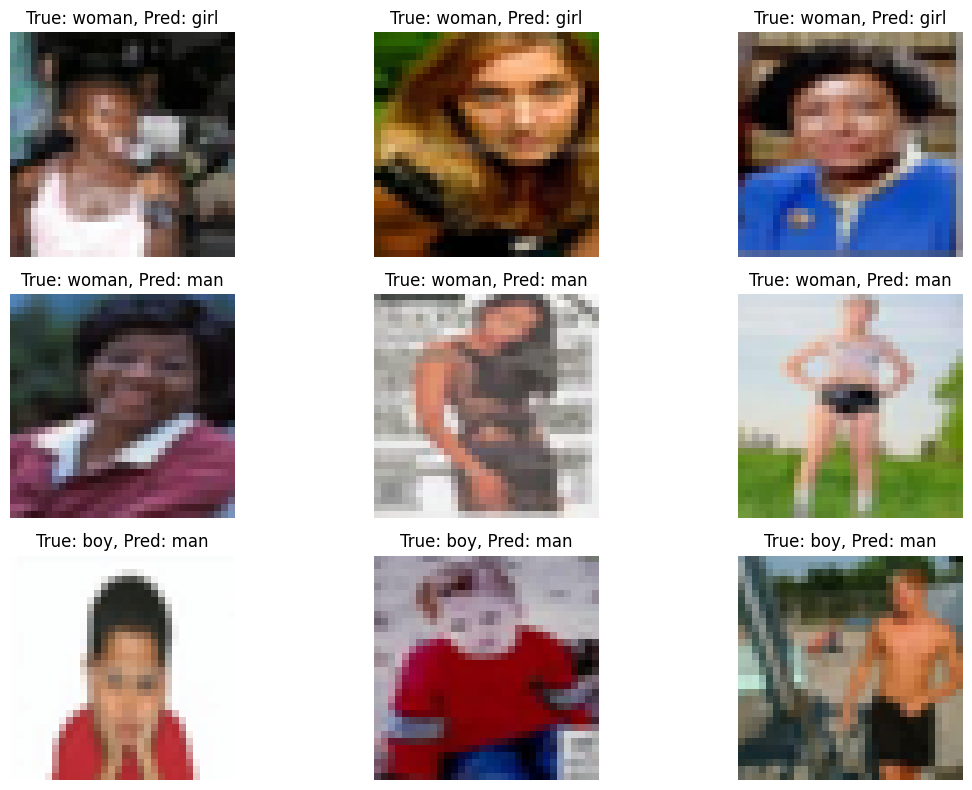

In [64]:
# 定义模型
model = SimpleCNN()

# 加载 CIFAR-10 的预训练权重
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cifar_10_model = torch.load("CIFAR10_CNN1.pth", map_location=device)

# 加载权重时忽略最后一层
pretrained_dict = cifar_10_model
model_dict = model.state_dict()

# 过滤掉最后一层（fc_layers.8）的权重
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and "fc_layers.8" not in k}

# 更新模型的权重
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# 替换最后一层为适应 CIFAR-100 的分类层
model.fc_layers[8] = nn.Linear(256, 100)  # 输出改为 100 类
model = model.to(device)

# 冻结卷积层权重
#for param in model.conv_layers.parameters():
#    param.requires_grad = False

train_losses, validation_losses, train_accs, validation_accs = ModelTrainer(
    model, train_loader, validation_loader, epochs=90, lr=0.005
).train()

# 可视化训练/验证损失和准确率
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss trend")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(validation_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy trend")
plt.legend()

plt.tight_layout()
plt.show()

# 测试模型
evaluate_model(model, test_loader)